# Produce geometrical XY map

<i>
This notebook takes a clean kDST and a correction file,
performs the lifetime correction and measures the energy
at different points of the XY plane. The resulting map
is stored in the same correction file.
</i>

### Notebook configuration

In [1]:
run_number          = 5813
input_dst_filename  = f"$IC_DATA/RunIV/kdst_{run_number}_filtered.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"
overwrite           = True

Zrange  =  100,  550
XYrange = -200,  200
Znbins  =   10
XYnbins =  100

# Plotting style
default_cmap = "viridis"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time
import collections
import warnings

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels

from table_info import MapInfo

labels = conditional_labels(with_titles)
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename   = os.path.expandvars( input_dst_filename)
correction_filename  = os.path.expandvars(correction_filename)

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 657993 
Total number of events: 648138


In [5]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(correction_filename,
                                                 group = "XYcorrections",
                                                 node  = "Elifetime")

ZcorrectionQ = dstf.load_lifetime_xy_corrections(correction_filename,
                                                 group = "XYcorrections",
                                                 node  = "Qlifetime")

In [6]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values * ZcorrectionE(Z, X, Y).value
Q = dst.S2q.values * ZcorrectionQ(Z, X, Y).value

### Event distribution

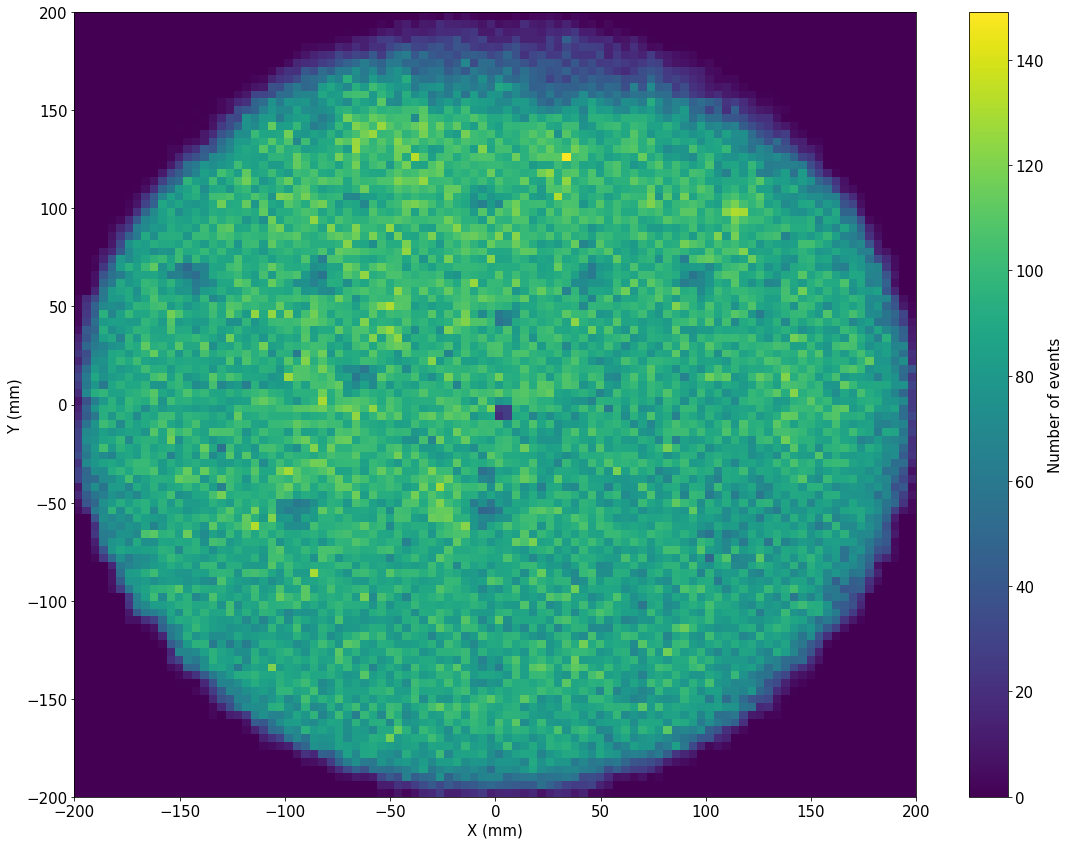

In [7]:
Nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Event_distribution_different_pitches_XY")

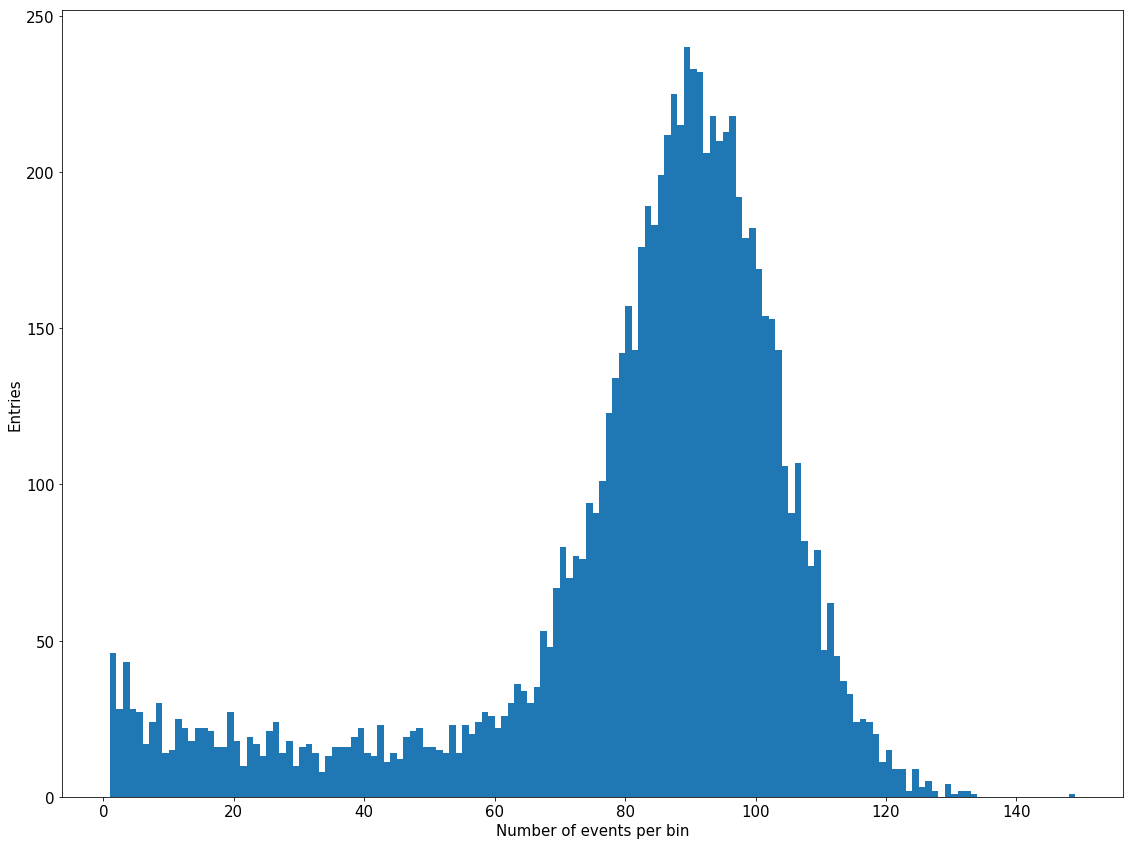

In [8]:
Nevt_max = int(np.max(Nevt))
bins = np.arange(Nevt_max) + 1
plt.hist(Nevt.flatten(), bins)
labels("Number of events per bin", "Entries", f"# events per bin for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Event_distribution_different_pitches")

### Fit example

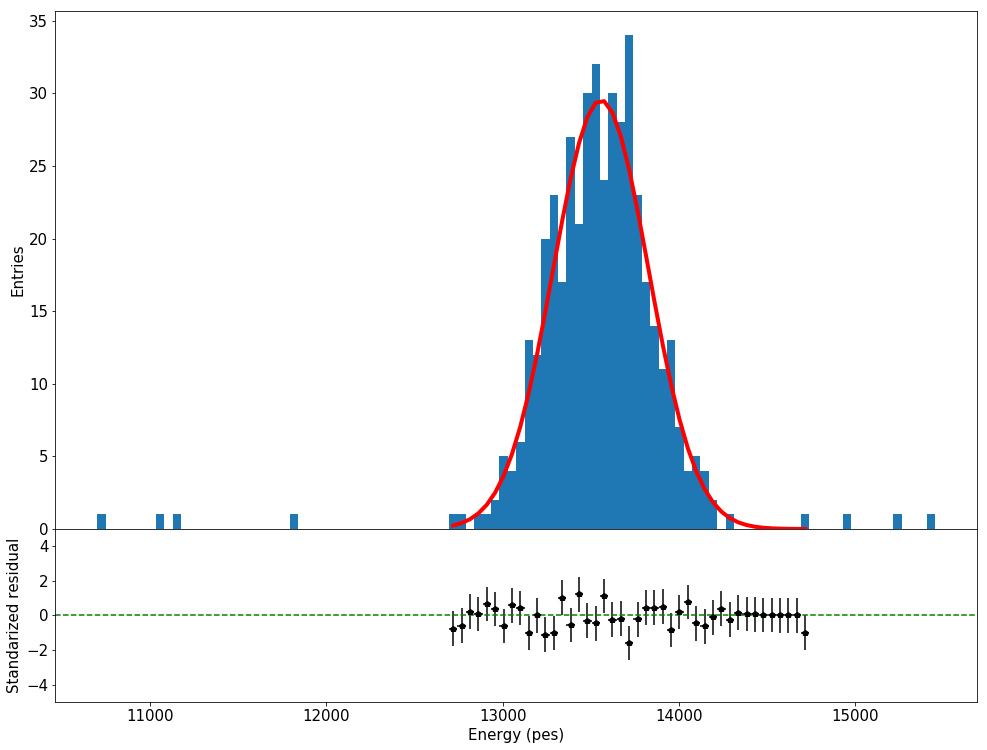

In [9]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
e    = E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(e, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 1.5 * seed[2], seed[1] + 1.5 * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Energy (pes)", "Standarized residual")

save("Energy_fit_example")

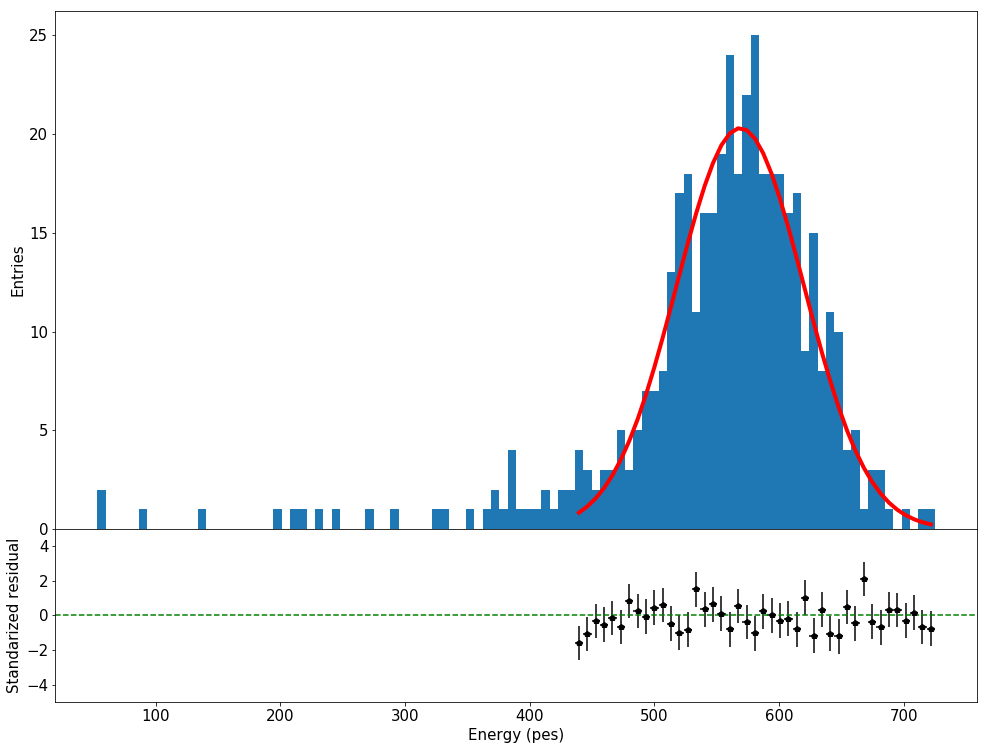

In [10]:
xlim =  15,  20
ylim = -25, -10
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
q    = Q[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = hist(q, 100, new_figure=False)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 5 * seed[2], seed[1] + 5 * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Entries", "Energy fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Energy (pes)", "Standarized residual")

save("Charge_fit_example")

### Compute geometry map

In [11]:
*_, Eave, Eaveu = fitf.profileXY(X, Y, E, XYnbins, XYnbins, XYrange, XYrange)
*_, Qave, Qaveu = fitf.profileXY(X, Y, Q, XYnbins, XYnbins, XYrange, XYrange)

Eaveu_rel = relative_errors(Eave, Eaveu, percentual=True)
Qaveu_rel = relative_errors(Qave, Qaveu, percentual=True)

Eok = Eave > 1e3
Qok = Qave > 1e1

E_min = np.percentile(Eave[Eok],  0.1)
E_max = np.percentile(Eave[Eok], 99.9)

Eu_min = np.percentile(Eaveu_rel[Eok],  1.0)
Eu_max = np.percentile(Eaveu_rel[Eok], 95.0)

Q_min = np.percentile(Qave[Eok],  1.0)
Q_max = np.percentile(Qave[Eok], 99.9)

Qu_min = np.percentile(Qaveu_rel[Eok],  1.0)
Qu_max = np.percentile(Qaveu_rel[Eok], 95.0)

### Energy map display

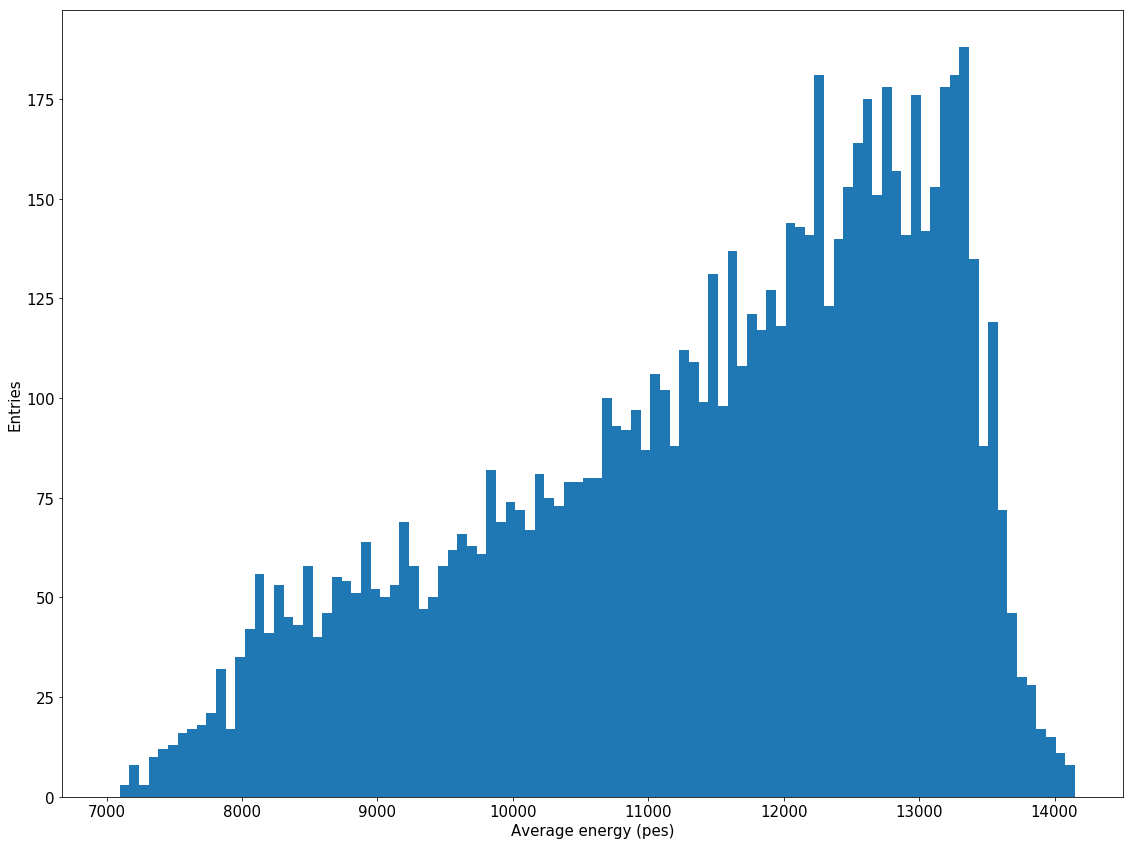

In [12]:
bins = np.linspace(E_min, E_max, 101)
plt.hist(Eave.flatten(), bins)
labels("Average energy (pes)", "Entries", f"Average energy for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_distributions")

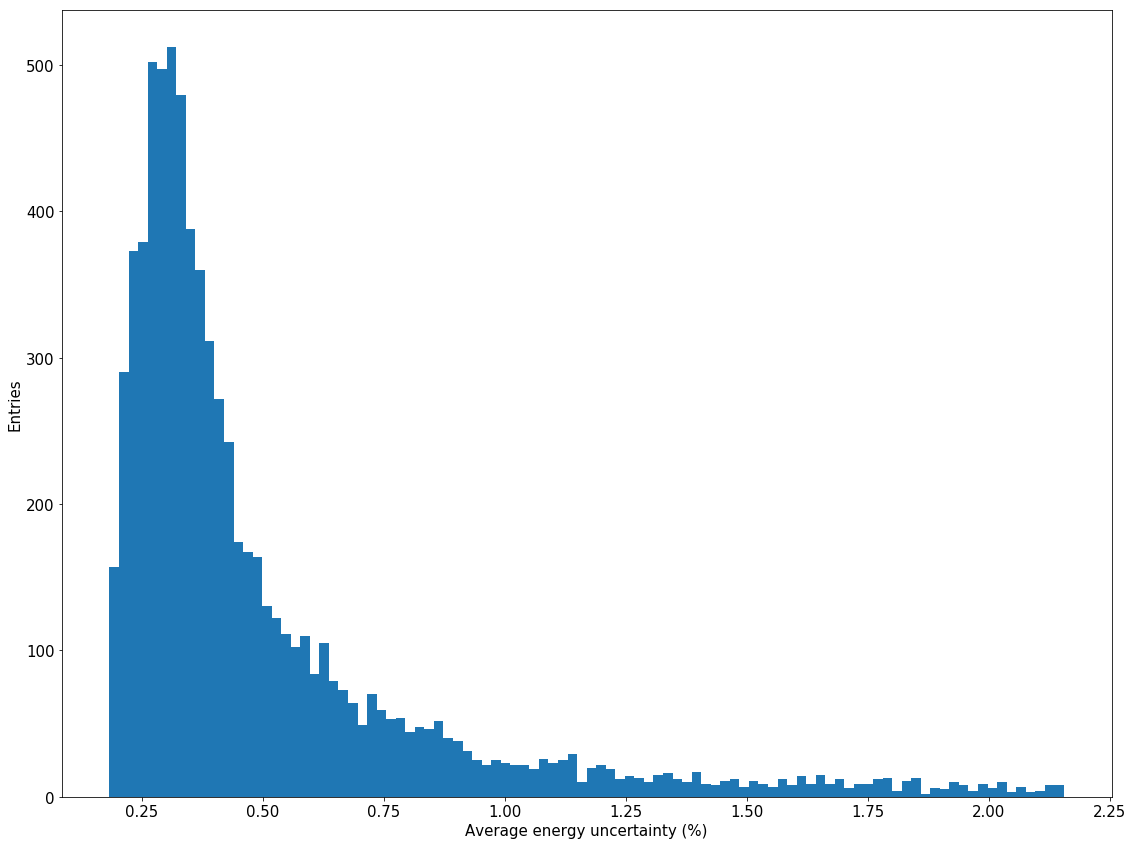

In [13]:
bins = np.linspace(Eu_min, Eu_max, 101)
plt.hist(Eaveu_rel.flatten(), bins)
labels("Average energy uncertainty (%)", "Entries", f"Average energy unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_distributions")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


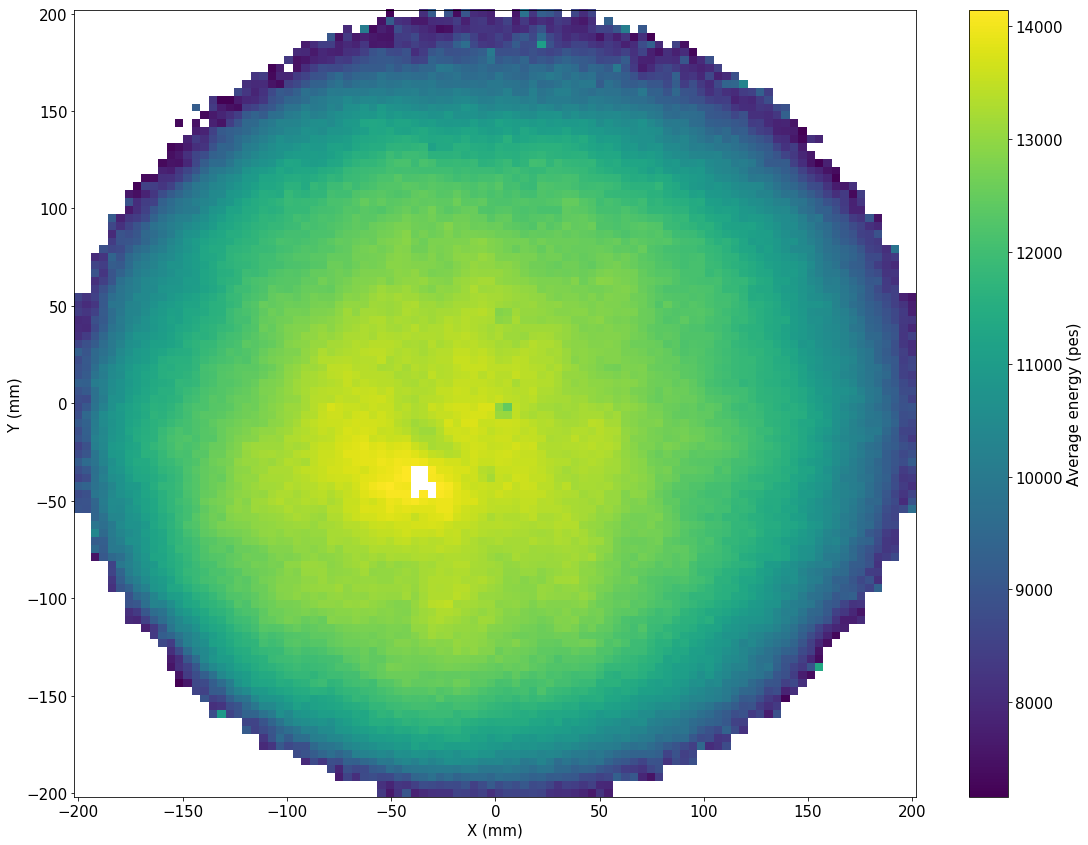

In [14]:
*_, cb = display_matrix(XYcenters, XYcenters, Eave,
                        cmin = E_min,
                        cmax = E_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", f"Average energy for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_maps")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


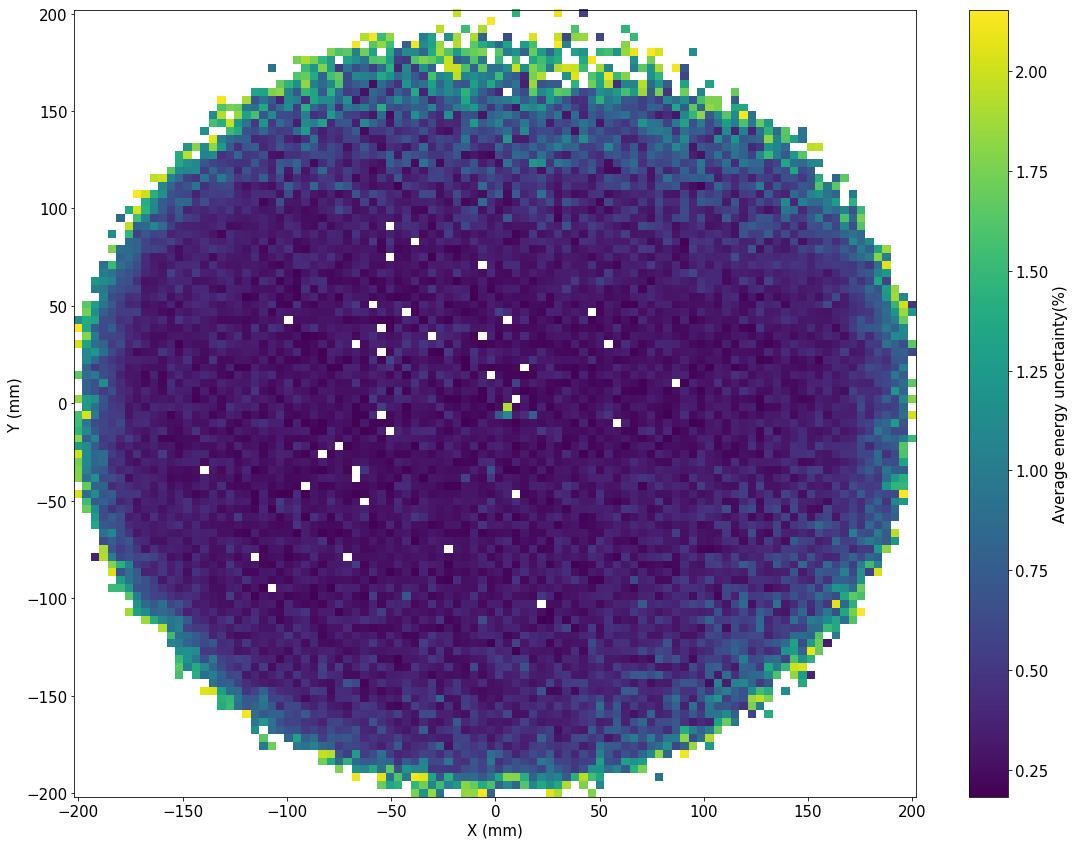

In [15]:
*_, cb = display_matrix(XYcenters, XYcenters, Eaveu_rel,
                        cmin = Eu_min,
                        cmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average energy unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Energy_uncertainty_maps")

### Charge map display

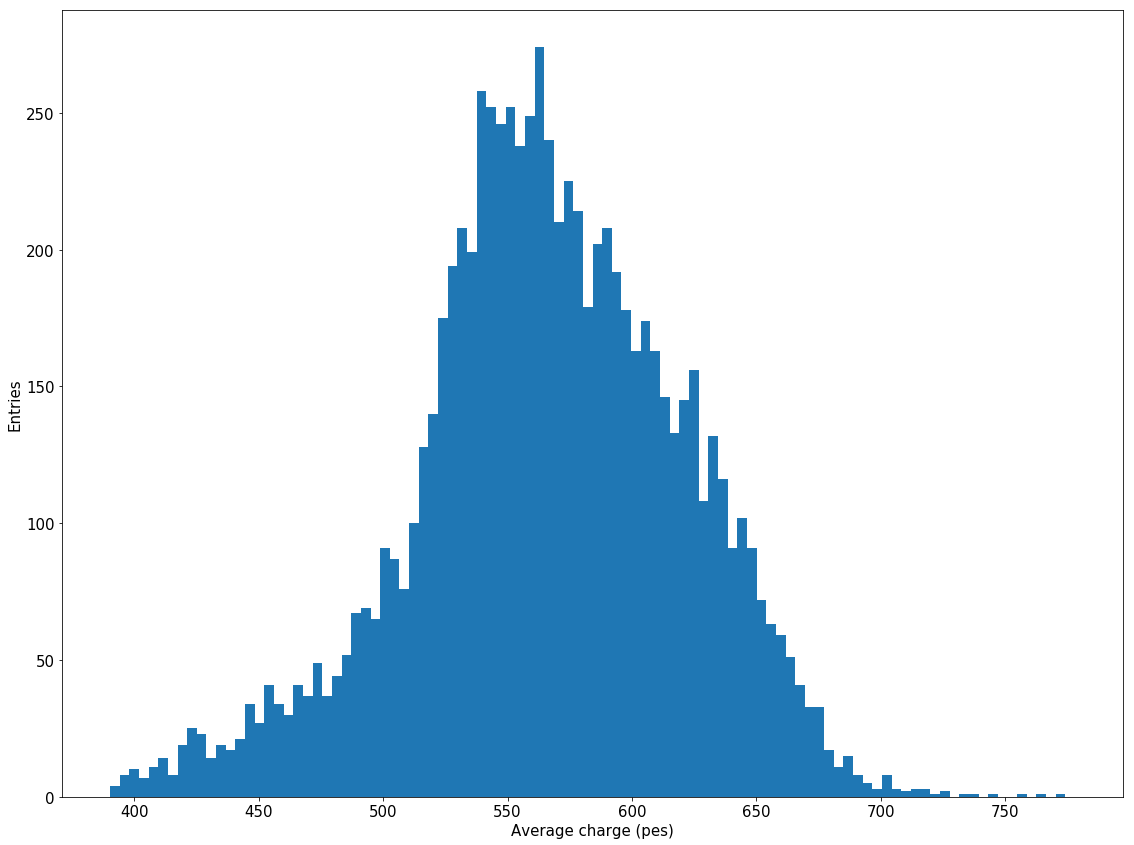

In [16]:
bins = np.linspace(Q_min, Q_max, 101)
plt.hist(Qave.flatten(), bins)
labels("Average charge (pes)", "Entries", f"Average charge for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_distributions")

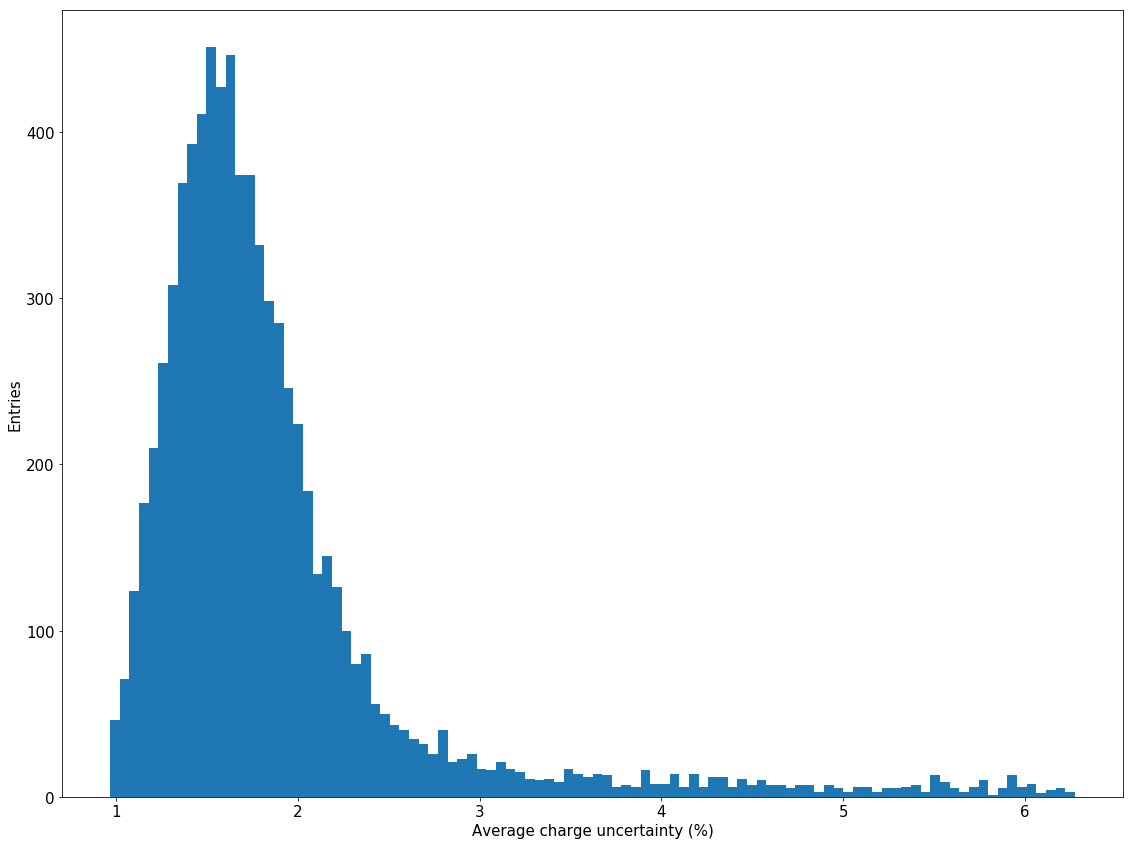

In [17]:
bins = np.linspace(Qu_min, Qu_max, 101)
plt.hist(Qaveu_rel.flatten(), bins)
labels("Average charge uncertainty (%)", "Entries", f"Average charge unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_distributions")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


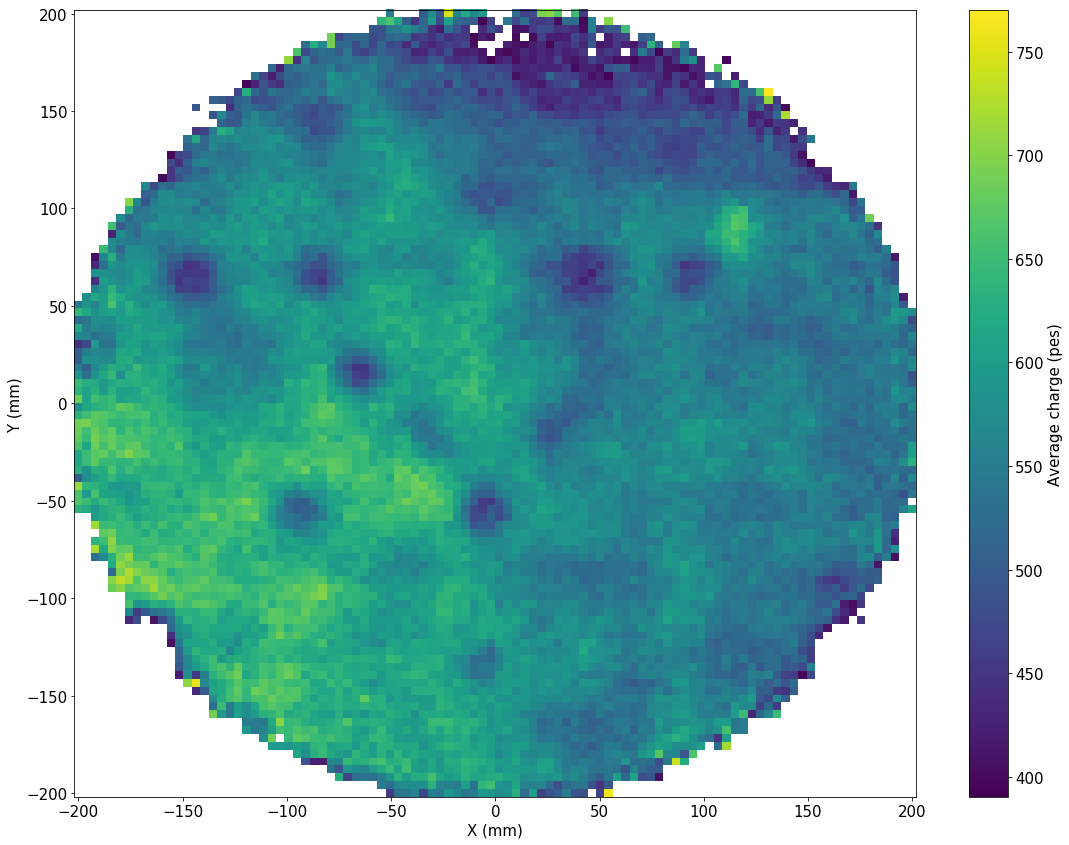

In [18]:
*_, cb = display_matrix(XYcenters, XYcenters, Qave,
                        cmin = Q_min,
                        cmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average charge (pes)")
labels("X (mm)", "Y (mm)", f"Average charge for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_maps")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


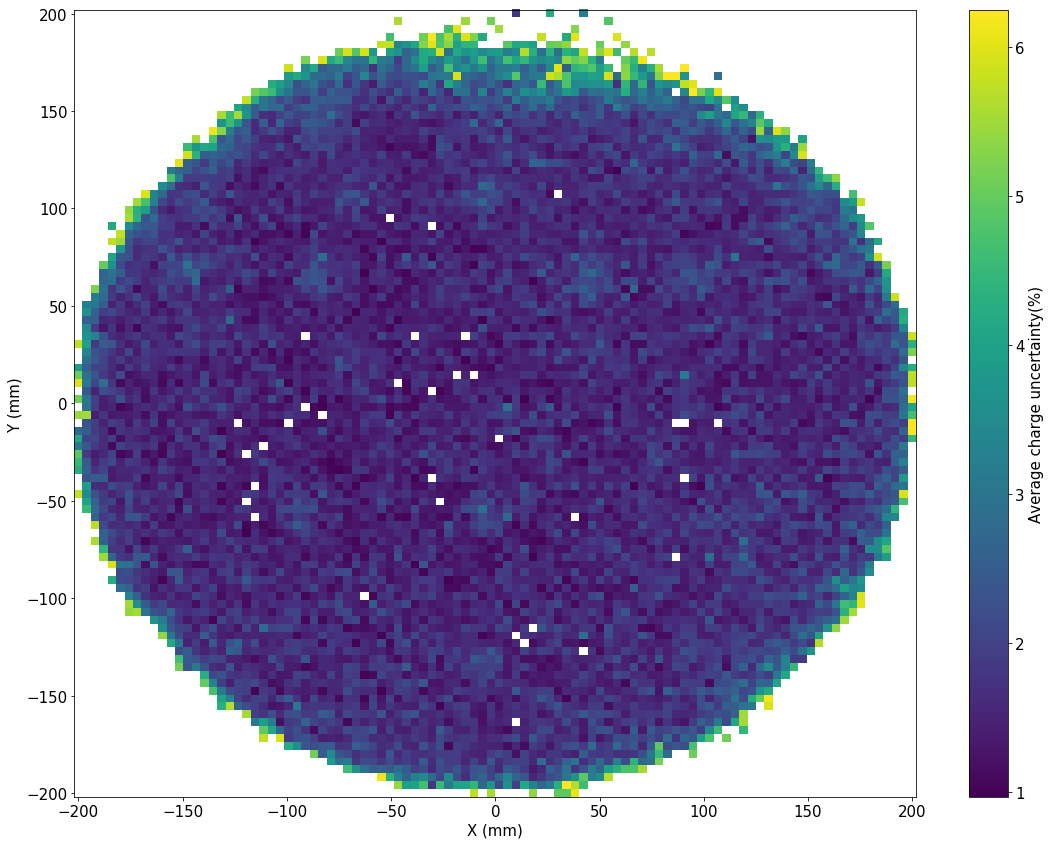

In [19]:
*_, cb = display_matrix(XYcenters, XYcenters, Qaveu_rel,
                        cmin = Qu_min,
                        cmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average charge uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average charge unc. for {XYpitch:.1f} mm pitch")

plt.tight_layout()
save("Charge_uncertainty_maps")

### Produce HDF5 output

In [20]:
with tb.open_file(correction_filename, "a") as correction_file:
    map_table = correction_file.create_table(correction_file.root, "GEOMapInfo", MapInfo, "Map metadata")

    row = map_table.row
    row["x_nbins"] = XYnbins
    row["y_nbins"] = XYnbins
    row["x_pitch"] = XYpitch
    row["y_pitch"] = XYpitch
    row["x_min"  ] = XYrange[0]
    row["x_max"  ] = XYrange[1]
    row["y_min"  ] = XYrange[0]
    row["y_max"  ] = XYrange[1]
    row.append()

In [21]:
with tb.open_file(correction_filename, "r+") as output_file:
    group      = "XYcorrections"
    table_name = "Egeometry"
    if (overwrite                                      and
        group      in output_file.root                 and
        table_name in getattr(output_file.root, group)):
        output_file.remove_node(getattr(output_file.root, group), table_name)
    write = kdstio.xy_correction_writer(output_file,
                                        group      = group,
                                        table_name = table_name)
    write(XYcenters, XYcenters, Eave, Eaveu * Eave / 100, Nevt)

    table_name = "Qgeometry"
    if (overwrite                                      and
        group      in output_file.root                 and
        table_name in getattr(output_file.root, group)):
        output_file.remove_node(getattr(output_file.root, group), table_name)
    write = kdstio.xy_correction_writer(output_file,
                                        group      = group,
                                        table_name = table_name)
    write(XYcenters, XYcenters, Qave, Qaveu * Qave / 100, Nevt)